# Obs zonal mean

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
from gsw import SA_from_SP, p_from_z, sigma1, CT_from_t, sigma0, sigma4
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import cartopy.crs as ccrs

from dask.distributed import Client

In [2]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41587 Dashboard: /proxy/45447/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


Load WOA data (downloaded from https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl )

In [4]:
temp_obs = xr.open_dataset('/g/data/x77/cy8964/Post_Process/Observations/woa18_8594_t00_04.nc',decode_times=False )
salt_obs = xr.open_dataset('/g/data/x77/cy8964/Post_Process/Observations/woa18_8594_s00_04.nc',decode_times=False )

In [5]:
temp_obs = temp_obs.isel(time = 0).sel(lat = slice(-90,-30)).t_an
salt_obs = salt_obs.isel(time = 0).sel(lat = slice(-90,-30)).s_an


load model data

In [6]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [7]:
expt = '01deg_jra55v13_ryf9091'

In [8]:
salt = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/salttemp_10yr.nc').salt
temp = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/salttemp_10yr.nc').temp


find abs salinity from psu, so that sigma1 can be calculated

In [9]:
st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1)
depth = xr.zeros_like(salt) -salt.st_ocean
lat = xr.zeros_like(salt) + salt.yt_ocean
lon = xr.zeros_like(salt) + salt.xt_ocean

pressure = p_from_z(depth,lat)

# absolute salinity model:
abs_salt = SA_from_SP(salt,pressure,lon,lat)

depth = xr.zeros_like(salt_obs) -salt_obs.depth
lat = xr.zeros_like(salt_obs) + salt_obs.lat
lon = xr.zeros_like(salt_obs) + salt_obs.lon
pressure = p_from_z(depth,lat)

# absolute salinity obs:
abs_salt_obs = SA_from_SP(salt_obs,pressure,lon,lat)


In [10]:
sigma1_model = sigma1(abs_salt,temp)
# model has in situ temp - move to conservative temp
CT = CT_from_t(abs_salt_obs,temp_obs,pressure)
sigma1_obs = sigma1(abs_salt_obs,CT)

In [11]:
CT = CT.load()

In [12]:
salt_interp = salt.interp(yt_ocean = salt_obs.lat,  st_ocean =salt_obs.depth)
temp_interp = temp.interp(yt_ocean = temp_obs.lat,  st_ocean =temp_obs.depth)

In [13]:
newcmap = cmocean.tools.crop_by_percent(cmocean.thermal, 15, which='min', N= None)

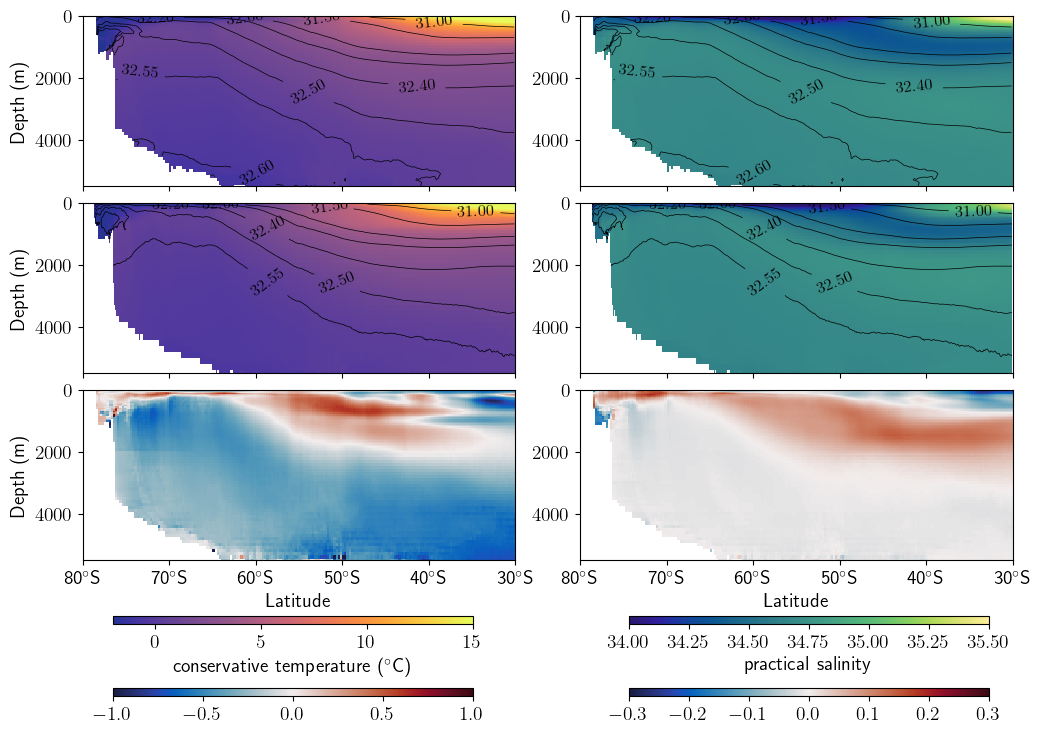

In [17]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,8), sharex=True)
CT.mean('lon').plot(ax = axes[0,0],vmax = 15, vmin = -2, cmap = newcmap, add_colorbar = False)
CS = sigma1_obs.mean('lon').plot.contour(ax = axes[0,0],levels = [31,31.5,32,32.2,32.4,32.55,32.5,32.6], colors = 'k', linewidths = 0.5)
axes[0,0].clabel(CS, [31,31.5,32,32.2,32.4,32.55,32.5,32.6], inline=True, fontsize=12)
axes[0,0].set_ylim(5500,0)
axes[0,0].set_xlim(-80,-30)
axes[0,0].set_title('')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Depth (m)')

salt_obs.mean('lon').plot(ax = axes[0,1], cmap = 'cmo.haline', vmin = 34, vmax = 35.5, add_colorbar = False)
CS = sigma1_obs.mean('lon').plot.contour(ax = axes[0,1],levels = [31,31.5,32,32.2,32.4,32.55,32.5,32.6], colors = 'k', linewidths = 0.5)
axes[0,1].clabel(CS, [31,31.5,32,32.2,32.4,32.55,32.5,32.6], inline=True, fontsize=12)
axes[0,1].set_ylim(5500,0)
axes[0,1].set_xlim(-80,-30)
axes[0,1].set_title('')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

p1 = temp.mean('xt_ocean').plot(ax = axes[1,0],vmax = 15, vmin = -2, cmap = newcmap, add_colorbar = False)
CS = sigma1_model.mean('xt_ocean').plot.contour(ax = axes[1,0],levels = [31,31.5,32,32.2,32.4,32.55,32.5,32.6], colors = 'k', linewidths = 0.5)
axes[1,0].clabel(CS, [31,31.5,32,32.2,32.4,32.5,32.55,32.6], inline=True, fontsize=12)
axes[1,0].set_ylim(5500,0)
axes[1,0].set_title('')
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Depth (m)')

p2 =(salt).mean('xt_ocean').plot(ax = axes[1,1], cmap = 'cmo.haline', vmin = 34, vmax = 35.5, add_colorbar = False)
CS = sigma1_model.mean('xt_ocean').plot.contour(ax = axes[1,1],levels = [31,31.5,32,32.2,32.4,32.55,32.5,32.6], colors = 'k', linewidths = 0.5)
axes[1,1].clabel(CS, [31,31.5,32,32.2,32.4,32.5,32.55,32.6], inline=True, fontsize=12)
axes[1,1].set_ylim(5500,0)
axes[1,1].set_title('')
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')

p3 = (temp_interp.mean('xt_ocean')-temp_obs.mean('lon')).plot(ax = axes[2,0], cmap = 'cmo.balance', vmin = -1, vmax = 1, add_colorbar = False)
axes[2,0].set_ylim(5500,0)
axes[2,0].set_title('')
axes[2,0].set_xlabel('Latitude')
axes[2,0].set_ylabel('Depth (m)')
axes[2,0].set_xlim(-80,-30)

p4 = (salt_interp.mean('xt_ocean')-salt_obs.mean('lon')).plot(ax = axes[2,1], cmap = 'cmo.balance', vmin = -0.3, vmax = 0.3, add_colorbar = False)
axes[2,1].set_ylim(5500,0)
axes[2,1].set_title('')
axes[2,1].set_xlabel('Latitude')
axes[2,1].set_ylabel('')
axes[2,1].set_xlim(-80,-30)

plt.subplots_adjust(wspace = 0.15, hspace = 0.1, bottom =0.2)
ax_cb = plt.axes([0.15, 0.12, 0.3, 0.01])
cb = plt.colorbar(p1,cax=ax_cb, orientation='horizontal')
cb.ax.set_xlabel('conservative temperature ($^\circ$C)');
#cb.ax.tick_params(labelsize=14)
ax_cb = plt.axes([0.58, 0.12, 0.3, 0.01])
cb = plt.colorbar(p2,cax=ax_cb, orientation='horizontal')
cb.ax.set_xlabel('practical salinity');

ax_cb = plt.axes([0.15, 0.03, 0.3, 0.01])
cb = plt.colorbar(p3,cax=ax_cb, orientation='horizontal')
#ax_cb.yaxis.set_ticks_position('top')#cb.ax.set_ylabel('conservative temperature ($^\circ$C)');

ax_cb = plt.axes([0.58, 0.03, 0.3, 0.01])
cb = plt.colorbar(p4,cax=ax_cb, orientation='horizontal')
#cb.ax.set_ylabel('potential salinity');
#ax_cb.yaxis.set_ticks_position('top')

X = np.arange(-80,-29,10)
# axes[1,1].set_xticks(X)
# axes[1,1].set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S'));
# axes[0,0].set_xticks(X)
# axes[0,0].set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S'));
# axes[1,0].set_xticks(X)
# axes[1,0].set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S'));
# axes[0,1].set_xticks(X)
# axes[0,1].set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S'));
axes[2,0].set_xticks(X)
axes[2,0].set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S'));
axes[2,1].set_xticks(X)
axes[2,1].set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S'));
#fig.suptitle('Zonal mean model and observation comparison')
fig.savefig('obs.png',dpi = 400)